In [1]:
import pandas as pd
import zipfile
from elopy.elo import Elo
import matplotlib.pyplot as plt

In [2]:
with zipfile.ZipFile('data/contest_results.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

df = pd.read_csv('./extracted_files/contest_results.csv', parse_dates=['contest_date'])
df.loc[df['placing'] > 16, 'placing'] = 16
df = df[['organization', 'contest_name', 'contest_date', 'division', 'class', 'competitor_name', 'placing']]
df.loc[df["division"] == "women\'s wellness", "division"] = "wellness"
df = df.dropna()

In [3]:
# every pair of competitors from the same show & division get a row
# think of this as a "match" in chess
df_merge = pd.merge(df,
                    df,
                    on=['organization', 'contest_name', 'contest_date', 'division', 'class'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

In [4]:
df_merge = df_merge[df_merge['placing_winner'] < df_merge['placing_loser']]
df_merge.head()

,organization,contest_name,contest_date,division,class,competitor_name_winner,placing_winner,competitor_name_loser,placing_loser
6,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,tasha chase,5.0,laura mcintosh,6.0
12,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,sarah farrer,4.0,laura mcintosh,6.0
13,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,sarah farrer,4.0,tasha chase,5.0
18,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,neha dhanda,3.0,laura mcintosh,6.0
19,cpa,cpa fedel clarke classic,2018-03-25,bikini,class a,neha dhanda,3.0,tasha chase,5.0


# Elo Rating Column
Here we will create a column in df_merge which includes the competitor's Elo rating leading up to that competition.

In [5]:
df = df.sort_values(
    by=[
        "contest_date",
        "organization",
        "contest_name",
        "division",
        "class",
        "competitor_name"
    ],
    ascending=True,
)

In [6]:
competitors = {}
starting_elo = {"bikini": 1767,
                "figure": 1616,
                "fitness": 1516,
                "men\'s bodybuilding": 1651,
                "men\'s classic physique": 1691,
                "men\'s physique": 1688,
                "wellness": 1612,
                "women\'s bodybuilding": 1570,
                "women\'s physique": 1547,
                "212": 1651}

for contest_date in df["contest_date"].unique():
    for index, row in df[df["contest_date"] == contest_date].iterrows():

        if row["competitor_name"] not in competitors:
            if row["organization"] != "ifbb":
                competitors[row["competitor_name"]] = Elo(hca = 0)
            else:
                div = row["division"]
                competitors[row["competitor_name"]] = Elo(start_elo=starting_elo[div], hca = 0)
        df.loc[index, f"elo_rating"] = competitors[row["competitor_name"]].elo

    for index, row in df_merge[df_merge["contest_date"] == contest_date].iterrows():
        winner = row["competitor_name_winner"]
        loser = row["competitor_name_loser"]
        rank_diff = row["placing_loser"] - row["placing_winner"]

        competitors[winner].play_game(competitors[loser], rank_diff)

In [7]:
df[f"elo_rank"] = df.groupby(
    ["organization", "contest_date", "contest_name", "division", "class"]
)[f"elo_rating"].rank(ascending=False, method="first")
# df.loc[df["elo_rank"] > 16, "elo_rank"] = 16

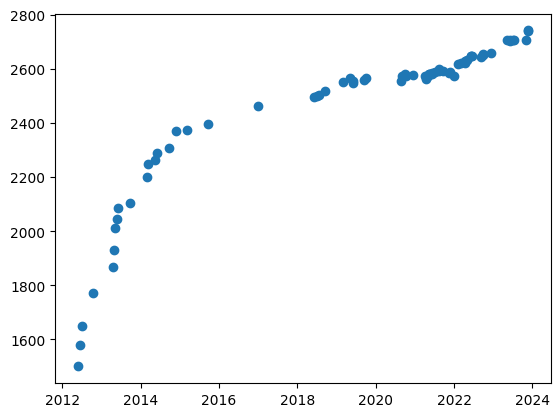

In [8]:
plt.scatter(df[df['competitor_name'] == 'ashley kaltwasser']['contest_date'],
            df[df['competitor_name'] == 'ashley kaltwasser'][f'elo_rating'])

In [9]:
df.head()

,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,1516.0,1.0
17030,ifbb,ifbb flex pro,2012-02-18,fitness,open,allison ethier,9.0,1516.0,2.0
17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,1516.0,3.0
17031,ifbb,ifbb flex pro,2012-02-18,fitness,open,camala rodriguez,8.0,1516.0,4.0
17033,ifbb,ifbb flex pro,2012-02-18,fitness,open,jodi boam,6.0,1516.0,5.0


In [10]:
df.to_csv('contest_results_elo_adjusted.csv')

In [11]:
max_date = df['contest_date'].max()

df[df['contest_date'] == max_date]['elo_rating'].mean()

1516.0716628713642

In [12]:
olympia_date = df[df['contest_name'].str.contains('mr olympia')]["contest_date"].max()

In [13]:
olympia_date

Timestamp('2023-11-03 00:00:00')

In [14]:
top_10_elo = df.sort_values("elo_rating", ascending=False)[df["contest_date"] == olympia_date].groupby("division").head(10)

/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_25931/305452494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_10_elo = df.sort_values("elo_rating", ascending=False)[df["contest_date"] == olympia_date].groupby("division").head(10)


In [15]:
top_10 = df.sort_values("placing", ascending=True)[df["contest_date"] == olympia_date].groupby("division").head(10)

/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_25931/397030513.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_10 = df.sort_values("placing", ascending=True)[df["contest_date"] == olympia_date].groupby("division").head(10)


In [16]:
top_10[top_10["division"] == "bikini"]

,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
73527,ifbb,ifbb mr olympia,2023-11-03,bikini,open,jennifer dorie,1.0,2732.674575,1.0
73526,ifbb,ifbb mr olympia,2023-11-03,bikini,open,maureen blanquisco,2.0,2639.491939,4.0
73525,ifbb,ifbb mr olympia,2023-11-03,bikini,open,ashley kaltwasser,3.0,2707.602024,3.0
73524,ifbb,ifbb mr olympia,2023-11-03,bikini,open,lauralie chapados,4.0,2707.872765,2.0
73523,ifbb,ifbb mr olympia,2023-11-03,bikini,open,elisa pecini,5.0,2615.212892,5.0
73522,ifbb,ifbb mr olympia,2023-11-03,bikini,open,aimee leann delgado,6.0,2491.275470,7.0
73521,ifbb,ifbb mr olympia,2023-11-03,bikini,open,ariana brothers,7.0,2133.321158,25.0
73520,ifbb,ifbb mr olympia,2023-11-03,bikini,open,ashlyn little,8.0,2322.838936,12.0
73519,ifbb,ifbb mr olympia,2023-11-03,bikini,open,daraja hill,9.0,2541.926683,6.0
73518,ifbb,ifbb mr olympia,2023-11-03,bikini,open,jourdanne lee,10.0,2408.333596,9.0
